In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import jax
#jax.config.update('jax_platform_name', 'cpu')

In [3]:
from entot.plotting.plots import plot_1D, plot_images
from entot.models.models import KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
from numpy import genfromtxt
from entot.nets.nets import UNet

2023-06-16 17:47:25.420866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mnist = tf.keras.datasets.mnist.load_data()[1][0]

In [5]:
mnist_resized = tf.image.resize(mnist[...,None], (32, 32))
mnist_resized = jnp.array(mnist_resized) / 255.

2023-06-16 17:47:30.162196: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
my_data = genfromtxt('/home/dominikk/data/handwritten_data.csv', delimiter=',')

In [7]:
my_data_reshaped = np.reshape(my_data[...,:-1], (-1, 28, 28))
rng = jax.random.PRNGKey(0)
random_indices = jax.random.choice(rng, len(my_data_reshaped), shape=(10_000,), replace=False)
alphabet_reduced = my_data_reshaped[random_indices]
alphabet_resized = tf.image.resize(alphabet_reduced[...,None], (32, 32))

In [8]:
alphabet_resized = jnp.array(alphabet_resized, dtype=jnp.float32) / 255.

In [9]:
neural_net = UNet(diff_input_output=1, base_factor=4)

In [10]:
kg = KantorovichGapModel(epsilon_kant_gap=1e-3, input_dim=[32,32, 1], noise_dim=1, neural_net=neural_net, callback=plot_images, k_noise_per_x=5, iterations=100, callback_iters=10)

In [46]:
kg(alphabet_resized, mnist_resized, 256, 256)

One epoch consists of 39.0625 iterations


  0%|          | 0/100 [00:00<?, ?it/s]2023-06-16 21:04:13.699002: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.00MiB (rounded to 5242880)requested by op 
2023-06-16 21:04:13.706072: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****************************************************************************************************
2023-06-16 21:04:13.706246: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2469] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5242880 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    5.00MiB
              constant allocation:         0B
        maybe_live_out allocation:    5.00MiB
     preallocated temp allocation:         0B
                 total allocation:   10.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 5.00MiB
		Entry Parameter Subsh

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5242880 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    5.00MiB
              constant allocation:         0B
        maybe_live_out allocation:    5.00MiB
     preallocated temp allocation:         0B
                 total allocation:   10.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 5.00MiB
		Entry Parameter Subshape: f32[1280,8,8,4,4]
		==========================

	Buffer 2:
		Size: 5.00MiB
		Operator: op_name="jit(mul)/jit(main)/mul" source_file="/home/dominikk/git_repos/entot/entot/nets/nets.py" source_line=16
		XLA Label: fusion
		Shape: f32[1280,8,8,4,4]
		==========================

	Buffer 3:
		Size: 4B
		Entry Parameter Subshape: f32[]
		==========================



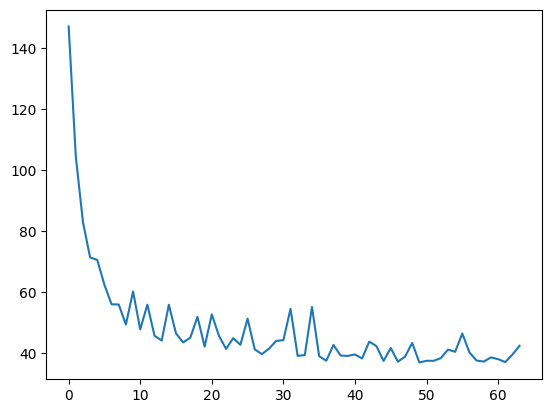

In [23]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

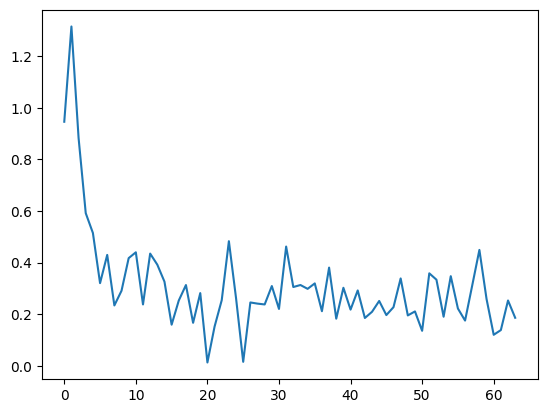

In [24]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["kant_gap"])

In [42]:
res = kg.transport(alphabet_resized[5,...][None,...], 2, 0)

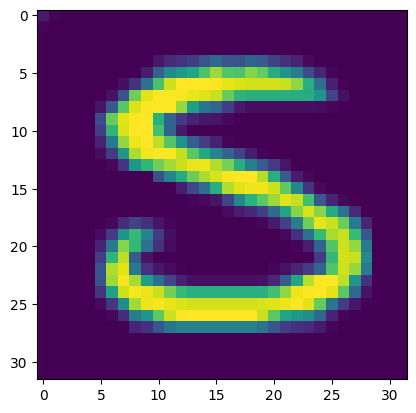

In [43]:
plt.imshow(jnp.squeeze(alphabet_resized[5,...]))

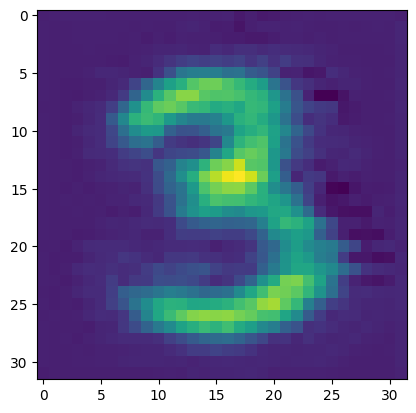

In [44]:
plt.imshow(jnp.squeeze(res[0,...]))

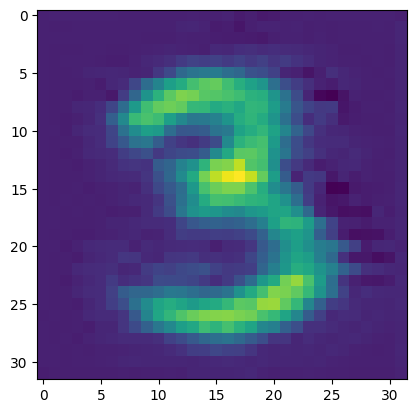

In [45]:
plt.imshow(jnp.squeeze(res[1,...]))

In [42]:
(res[1,...] - res[0,...]).min()

Array(-1.1870253, dtype=float32)

In [24]:
source = mnist_resized[:10,...]
target = mnist_resized[10:20,...]
T_xz = target

In [30]:
source.shape, target.shape
import ott
import ott.geometry.costs as costs

In [31]:
geom = ott.geometry.pointcloud.PointCloud(
x=jnp.reshape(source, (source.shape[0], -1)),
y=jnp.reshape(T_xz, (T_xz.shape[0], -1)),
)
id_displacement = jnp.mean(jax.vmap(costs.SqEuclidean())(source, T_xz))
sinkhorn_output = ott.solvers.linear.sinkhorn.Sinkhorn()(ott.problems.linear.linear_problem.LinearProblem(geom))  # linear_problem.LinearProblem(geom, a=a, b=b)

opt_displacement = sinkhorn_output.reg_ot_cost - 2 * geom.epsilon * jnp.log(
len(source)
)  # use Shannon entropy instead of relative entropy as entropic regularizer to ensure Monge gap positivity

r = id_displacement - opt_displacement, sinkhorn_output

In [43]:
source.shape

(10, 32, 32, 1)

In [47]:
source_flattened = jnp.reshape(source, (10,-1))
target_flattened = jnp.reshape(target, (10,-1))

In [49]:
jnp.mean(jax.vmap(costs.SqEuclidean())(source_flattened, target_flattened))

Array(112.14292, dtype=float32)

In [40]:
costs.SqEuclidean()(source, target)

Array([[[-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        ...,
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899]],

       [[-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        ...,
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
         -710.4899],
        [-710.4899, -710.4899, -710.4899, ..., -710.4899, -710.4899,
   